In [23]:
# we're installing from source since the model we will be using is brand new at the time of writing
!pip install --upgrade git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-3vv8zdts
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-3vv8zdts
  Resolved https://github.com/huggingface/transformers.git to commit 96eb06286b63c9c93334d507e632c175d6ba8b28
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [24]:
!pip install -q datasets
!pip install matplotlib
!pip install -U transformers
!pip install scikit-learn pillow torchvision opencv-python
!pip install tensorboardX
!pip install torch
!pip install numpy

In [3]:
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.6 MB/s eta 0:00:00


In [25]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset, DatasetDict, load_metric, Dataset
import numpy as np



In [5]:
!unzip lump.zip

Archive:  lump.zip
   creating: lump/
  inflating: lump/merged.csv         
  inflating: __MACOSX/lump/._merged.csv  
  inflating: lump/.DS_Store          
  inflating: __MACOSX/lump/._.DS_Store  
   creating: lump/images/
  inflating: lump/images/levle1_623_jpg.rf.a4372fd982824c8655a2aa4a999345cb.jpg  
  inflating: __MACOSX/lump/images/._levle1_623_jpg.rf.a4372fd982824c8655a2aa4a999345cb.jpg  
  inflating: lump/images/levle0_441_jpg.rf.511f8c6c5684c2a66704ab49ecb634fd.jpg  
  inflating: __MACOSX/lump/images/._levle0_441_jpg.rf.511f8c6c5684c2a66704ab49ecb634fd.jpg  
  inflating: lump/images/levle0_128_jpg.rf.d69b624976eb3a2f5bcfd66350e8e74e.jpg  
  inflating: __MACOSX/lump/images/._levle0_128_jpg.rf.d69b624976eb3a2f5bcfd66350e8e74e.jpg  
  inflating: lump/images/levle0_76_jpg.rf.25705de9259cca7015c71da2b0e3f1bf.jpg  
  inflating: __MACOSX/lump/images/._levle0_76_jpg.rf.25705de9259cca7015c71da2b0e3f1bf.jpg  
  inflating: lump/images/levle1_20_jpg.rf.fea4981d01dbc762b82e08b673785935.jpg 

In [26]:

import pandas as pd
csv_file = 'lump/merged.csv'
df = pd.read_csv(csv_file)
df.columns = df.columns.str.strip()
# Print the columns of the DataFrame
print("Columns in the DataFrame:", df.columns)

# Assuming 'filename' contains paths relative to a known base directory
base_dir = 'path_to_your_image_folder'

# Create a list of unique labels
labels = ['blackheads', 'dark spot', 'nodules', 'papules', 'pustules', 'whiteheads']

# # Convert labels to a list of multi-hot encoded vectors
# def create_multi_hot_label(row):
#     return [row[label] for label in labels]

# df['label'] = df.apply(create_multi_hot_label, axis=1)
# df['filename'] = df['filename'].apply(lambda x: f"{base_dir}/{x}")
dataset = Dataset.from_pandas(df)
# Split the dataset into train, validation, and test sets
ds = dataset.train_test_split(test_size=0.3)  # 70% train, 30% test
ds_test = ds['test'].train_test_split(test_size=0.5)  # 30% test --> 15% valid, 15% test

ds = DatasetDict({
    'train': ds['train'],
    'test': ds_test['test'],
    'valid': ds_test['train']
})

del ds_test

print(ds)

Columns in the DataFrame: Index(['filename', 'blackheads', 'dark spot', 'nodules', 'papules', 'pustules',
       'whiteheads'],
      dtype='object')
DatasetDict({
    train: Dataset({
        features: ['filename', 'blackheads', 'dark spot', 'nodules', 'papules', 'pustules', 'whiteheads'],
        num_rows: 878
    })
    test: Dataset({
        features: ['filename', 'blackheads', 'dark spot', 'nodules', 'papules', 'pustules', 'whiteheads'],
        num_rows: 189
    })
    valid: Dataset({
        features: ['filename', 'blackheads', 'dark spot', 'nodules', 'papules', 'pustules', 'whiteheads'],
        num_rows: 188
    })
})


In [27]:
example = ds['train'][0]
example

{'filename': 'levle1_452_jpg.rf.c2cb8a116b2abe20d0fd538d309f427c.jpg',
 'blackheads': 0,
 'dark spot': 1,
 'nodules': 0,
 'papules': 0,
 'pustules': 0,
 'whiteheads': 0}

In [28]:
labels = [label for label in ds['train'].features.keys() if label not in ['filename']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['blackheads', 'dark spot', 'nodules', 'papules', 'pustules', 'whiteheads']

In [29]:
from PIL import Image
import torchvision.transforms as transforms
import torch
from transformers import AutoImageProcessor, ViTForImageClassification
import transformers
class_labels = ['blackheads', 'dark spot', 'nodules', 'papules', 'pustules', 'whiteheads']

def transform(example_batch):
    desired_size = (224, 224)
    images = []
    root_dir = 'lump/images'
    # Load and resize images
    for img_path in example_batch['filename']:
        img = Image.open(f"{root_dir}/{img_path}").convert("RGB")
        img_resized = transforms.Resize(desired_size)(img)
        images.append(img_resized)

    # Process images with the processor
    inputs = processor(images, return_tensors='pt')

    # One-hot encode the labels
    labels_batch = {k.strip(): example_batch[k.strip()] for k in example_batch.keys() if k.strip() in class_labels}
    labels_matrix = torch.zeros((len(images), len(class_labels)))

    for idx, label in enumerate(class_labels):
        labels_matrix[:, idx] = torch.tensor(labels_batch[label])

    # Add labels to the inputs
    inputs['labels'] = labels_matrix
    # print(inputs)
    return inputs

# Apply the transform function to the dataset
prepared_ds = ds.with_transform(transform)
print(prepared_ds)

DatasetDict({
    train: Dataset({
        features: ['filename', 'blackheads', 'dark spot', 'nodules', 'papules', 'pustules', 'whiteheads'],
        num_rows: 878
    })
    test: Dataset({
        features: ['filename', 'blackheads', 'dark spot', 'nodules', 'papules', 'pustules', 'whiteheads'],
        num_rows: 189
    })
    valid: Dataset({
        features: ['filename', 'blackheads', 'dark spot', 'nodules', 'papules', 'pustules', 'whiteheads'],
        num_rows: 188
    })
})


In [30]:
def collate_fn(batch):
    pixel_values = torch.stack([x['pixel_values'] for x in batch])
    # print(pixel_values)
    # print([x['labels'] for x in batch])
    labels = torch.stack([x['labels'] for x in batch])
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }
metric = load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [31]:
from transformers import AutoImageProcessor, ViTForImageClassification
import accelerate
from transformers import AutoConfig, AutoModelForImageClassification
device = "cuda:0"
print(device)
cl = ['blackheads', 'dark_spot', 'nodules', 'papules', 'pustules', 'whiteheads']
model_id = "facebook/convnextv2-tiny-1k-224"
print({i: c for i, c in enumerate(cl)})
print({c: i for i, c in enumerate(cl)})
processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForImageClassification.from_pretrained(
    model_id,
    num_labels=6,
    id2label={str(i): c for i, c in enumerate(cl)},
    label2id={c: str(i) for i, c in enumerate(cl)},
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification"
)



cuda:0
{0: 'blackheads', 1: 'dark_spot', 2: 'nodules', 3: 'papules', 4: 'pustules', 5: 'whiteheads'}
{'blackheads': 0, 'dark_spot': 1, 'nodules': 2, 'papules': 3, 'pustules': 4, 'whiteheads': 5}


Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="modelconfig",
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
    num_train_epochs=20,
    logging_steps=500,
    learning_rate=2e-4,
    save_total_limit=1,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 964.5 kB/s eta 0:00:00


In [33]:
from transformers import Trainer
import evaluate
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
   return 1/(1 + np.exp(-x))

def compute_metrics(eval_pred):

   predictions, labels = eval_pred
   predictions = sigmoid(predictions)
   predictions = (predictions > 0.5).astype(int).reshape(-1)
   return clf_metrics.compute(predictions=predictions, references=labels.astype(int).reshape(-1))

In [19]:


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["valid"],
    tokenizer=processor,
)

In [ ]:


# def nll_loss(logits, labels):
#     return torch.nn.BCEWithLogitsLoss(logits, labels)

# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.logits
#         loss = nll_loss(logits, labels)

#         return (loss, outputs) if return_outputs else loss

# # use new trainer
# trainer = CustomTrainer(
#     model=model,
#     args=training_args,
#     data_collator=collate_fn,
#     compute_metrics=compute_metrics,
#     train_dataset=prepared_ds["train"],
#     eval_dataset=prepared_ds["valid"],
#     tokenizer=processor,
# )

In [20]:
save_dir = 'model'  # Define the path to save the model
train_results = trainer.train()
trainer.save_model(save_dir)  # Save the best model
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.606948,0.670213,0.345070,0.521277,0.257895
2,No log,0.595352,0.670213,0.345070,0.521277,0.257895
3,No log,0.595475,0.677305,0.518519,0.521277,0.515789
4,No log,0.591996,0.677305,0.518519,0.521277,0.515789
5,No log,0.596331,0.677305,0.518519,0.521277,0.515789
6,No log,0.597140,0.677305,0.518519,0.521277,0.515789
7,No log,0.589149,0.680851,0.505495,0.528736,0.484211
8,No log,0.589265,0.677305,0.518519,0.521277,0.515789
9,No log,0.586915,0.689716,0.504249,0.546012,0.468421


KeyboardInterrupt: 

In [37]:
def train_and_evaluate(model_id):
    print(f"Training and evaluating model: {model_id}")

    processor = AutoImageProcessor.from_pretrained(model_id)
    model = AutoModelForImageClassification.from_pretrained(
        model_id,
        num_labels=6,
        id2label={str(i): c for i, c in enumerate(cl)},
        label2id={c: str(i) for i, c in enumerate(cl)},
        ignore_mismatched_sizes=True,
        problem_type="multi_label_classification"
    )

    training_args = TrainingArguments(
        output_dir="modelconfig",
        per_device_train_batch_size=16,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        fp16=True,
        num_train_epochs=10,
        logging_steps=500,
        learning_rate=2e-4,
        save_total_limit=1,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to='tensorboard',
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=prepared_ds["train"],
        eval_dataset=prepared_ds["valid"],
        tokenizer=processor,
    )

    train_results = trainer.train()
    eval_results = trainer.evaluate()

    return eval_results

In [35]:
import matplotlib.pyplot as plt

Training and evaluating model: google/vit-base-patch16-224


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.554465,0.719858,0.419118,0.581633,0.327586
2,No log,0.524974,0.728723,0.559078,0.560694,0.557471
3,No log,0.488116,0.769504,0.606061,0.641026,0.574713
4,No log,0.493157,0.789894,0.654015,0.664688,0.643678
5,No log,0.569058,0.789007,0.632716,0.683333,0.589080
6,No log,0.600581,0.795213,0.663755,0.672566,0.655172
7,No log,0.614135,0.806738,0.663580,0.716667,0.617816
8,No log,0.625919,0.814716,0.691285,0.711246,0.672414
9,No log,0.632863,0.814716,0.691285,0.711246,0.672414
10,0.226900,0.635384,0.814716,0.690370,0.712538,0.669540


Training and evaluating model: openai/clip-vit-base-patch32


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch32 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.599758,0.718972,0.539913,0.545455,0.534483
2,No log,0.576240,0.718972,0.538574,0.545723,0.531609
3,No log,0.554024,0.712766,0.443299,0.551282,0.370690
4,No log,0.559275,0.694149,0.180523,0.520548,0.109195
5,No log,0.553413,0.722518,0.516229,0.558528,0.479885
6,No log,0.578573,0.716312,0.418182,0.569307,0.330460
7,No log,0.551737,0.705674,0.417544,0.536036,0.341954
8,No log,0.551848,0.723404,0.474747,0.573171,0.405172
9,No log,0.547007,0.734043,0.529781,0.582759,0.485632
10,0.595600,0.542580,0.728723,0.530675,0.569079,0.497126


Training and evaluating model: google/siglip-base-patch16-224


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

Some weights of SiglipForImageClassification were not initialized from the model checkpoint at google/siglip-base-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.569452,0.703014,0.129870,0.675676,0.071839
2,No log,0.553926,0.721631,0.543605,0.550000,0.537356
3,No log,0.549340,0.726064,0.522411,0.565217,0.485632
4,No log,0.556847,0.704787,0.327273,0.551020,0.232759
5,No log,0.560875,0.690603,0.005698,0.333333,0.002874
6,No log,0.586933,0.679078,0.456456,0.477987,0.436782
7,No log,0.561218,0.715426,0.484751,0.549091,0.433908
8,No log,0.553324,0.716312,0.504644,0.546980,0.468391
9,No log,0.564160,0.718972,0.499210,0.554386,0.454023
10,0.588000,0.572194,0.718085,0.500000,0.552083,0.456897


Training and evaluating model: microsoft/resnet-50


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([6, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,nan,0.691489,0.000000,0.000000,0.000000
2,No log,nan,0.691489,0.000000,0.000000,0.000000
3,No log,nan,0.691489,0.000000,0.000000,0.000000
4,No log,nan,0.691489,0.000000,0.000000,0.000000
5,No log,nan,0.691489,0.000000,0.000000,0.000000
6,No log,nan,0.691489,0.000000,0.000000,0.000000
7,No log,nan,0.691489,0.000000,0.000000,0.000000
8,No log,nan,0.691489,0.000000,0.000000,0.000000
9,No log,nan,0.691489,0.000000,0.000000,0.000000
10,0.000000,nan,0.691489,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training and evaluating model: facebook/convnextv2-tiny-1k-224


Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.540164,0.729610,0.548148,0.565749,0.531609
2,No log,0.515478,0.746454,0.566667,0.599359,0.537356
3,No log,0.502908,0.762411,0.592705,0.629032,0.560345
4,No log,0.479070,0.774823,0.618619,0.647799,0.591954
5,No log,0.481161,0.796099,0.629032,0.716912,0.560345
6,No log,0.533413,0.796986,0.647149,0.697674,0.603448
7,No log,0.540623,0.806738,0.672673,0.704403,0.643678
8,No log,0.546230,0.800532,0.658574,0.697749,0.623563
9,No log,0.567141,0.808511,0.672727,0.711538,0.637931
10,0.260300,0.569892,0.808511,0.667692,0.718543,0.623563


Training and evaluating model: apple/mobilevitv2-1.0-imagenet1k-256


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/19.8M [00:00<?, ?B/s]

Some weights of MobileViTV2ForImageClassification were not initialized from the model checkpoint at apple/mobilevitv2-1.0-imagenet1k-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([6, 512]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.667067,0.647163,0.500000,0.444196,0.571839
2,No log,0.623130,0.696809,0.530220,0.507895,0.554598
3,No log,0.582542,0.728723,0.571429,0.557377,0.586207
4,No log,0.560586,0.738475,0.561664,0.581538,0.543103
5,No log,0.546815,0.745567,0.564492,0.598071,0.534483
6,No log,0.535118,0.756206,0.586466,0.615142,0.560345
7,No log,0.525658,0.762411,0.597598,0.625786,0.571839
8,No log,0.532036,0.751773,0.587021,0.603030,0.571839
9,No log,0.546032,0.744681,0.580175,0.588757,0.571839
10,0.443700,0.538620,0.751773,0.589443,0.601796,0.577586


Training and evaluating model: google/mobilenet_v1_1.0_224


preprocessor_config.json:   0%|          | 0.00/406 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Some weights of MobileNetV1ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v1_1.0_224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1001, 1024]) in the checkpoint and torch.Size([6, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.514579,0.749113,0.536825,0.623574,0.471264
2,No log,0.502517,0.760638,0.565916,0.642336,0.505747
3,No log,0.500790,0.773936,0.613050,0.649518,0.580460
4,No log,0.545816,0.769504,0.585987,0.657143,0.528736
5,No log,0.611677,0.762411,0.596386,0.626582,0.568966
6,No log,0.589777,0.761525,0.618440,0.610644,0.626437
7,No log,0.600850,0.774823,0.592949,0.670290,0.531609
8,No log,0.575720,0.760638,0.613181,0.611429,0.614943
9,No log,0.680745,0.758865,0.614731,0.606145,0.623563
10,0.192600,0.570409,0.767730,0.614706,0.629518,0.600575


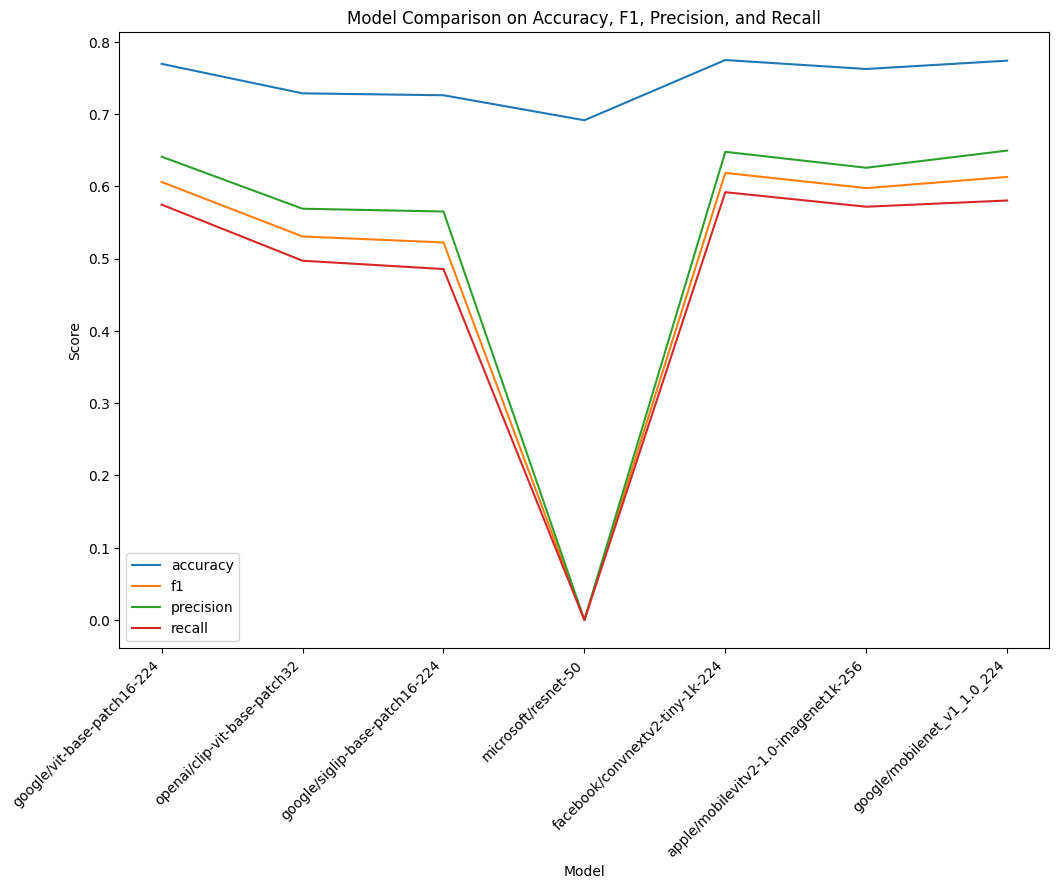

In [38]:
model_ids = [
    "google/vit-base-patch16-224",
    "openai/clip-vit-base-patch32",
    "google/siglip-base-patch16-224",
    "microsoft/resnet-50",
    "facebook/convnextv2-tiny-1k-224",
    "apple/mobilevitv2-1.0-imagenet1k-256",
    "google/mobilenet_v1_1.0_224"
]

metrics = {
    "model": [],
    "accuracy": [],
    "f1": [],
    "precision": [],
    "recall": []
}

for model_id in model_ids:
    eval_results = train_and_evaluate(model_id)
    metrics["model"].append(model_id)
    metrics["accuracy"].append(eval_results['eval_accuracy'])
    metrics["f1"].append(eval_results['eval_f1'])
    metrics["precision"].append(eval_results['eval_precision'])
    metrics["recall"].append(eval_results['eval_recall'])

# Plotting the results
plt.figure(figsize=(12, 8))

for metric in ['accuracy', 'f1', 'precision', 'recall']:
    plt.plot(metrics["model"], metrics[metric], label=metric)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Comparison on Accuracy, F1, Precision, and Recall')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()